In [1]:
import math
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
from board import Battleship

In [3]:
from utils import display_heatmap, plot_population_stats

## Setup The Target Board

In [4]:
battleship_board, battleship_solution = Battleship().create_board()

Correct number of pieces on board.


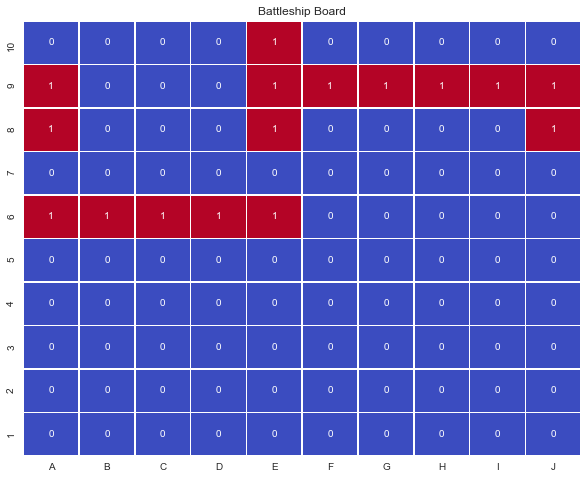

In [5]:
display_heatmap(data=battleship_board)

## Create a Random Guess

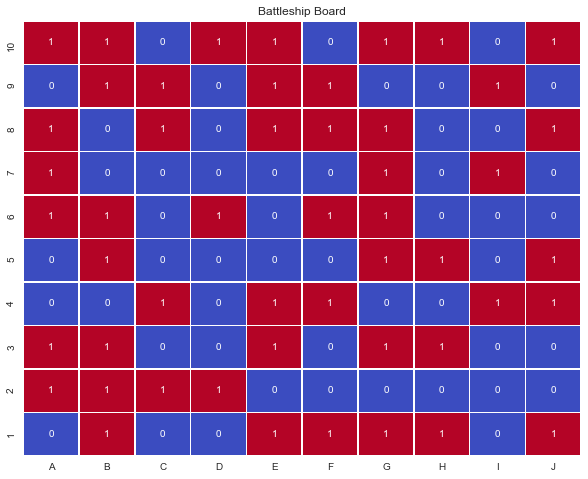

In [6]:
random_solution = np.random.randint(2, size=100).reshape((10, 10))

display_heatmap(data=random_solution)

## Define GA

In [7]:
class GeneticAlgorithm(object):
    """Generate GA for Battleship problem."""
    
    def __init__(self, num_generations=100):
        
        self.name = 'GA for Battleship board.'
        print('GA for Battleship board successfully initialized.')
    
    def generate_population(self, num_individuals, genes):
        
        # create dataframe for gene pool
        df_population = pd.DataFrame(columns=['Sequence', 'Chromosome', 'Generation', 'Birth', 'Fitness', 'Parents'])
        
        i = 0
        while i < num_individuals:
            
            individual = {
                'Sequence': i+1,
                'Chromosome': ''.join(str(x) for x in list(np.random.randint(2, size=genes))),
                'Generation': 1,
                'Birth': 'Random',
                'Parents': 0
            }
            
            # check for uniqueness and add to gene pool
            if individual['Chromosome'] not in df_population['Chromosome']:
                df_population = df_population.append(individual, ignore_index=True)
                i += 1
                
        # return the initial population
        return df_population

    def evaluate_fitness(self, actual_solution, candidate_solution):
        
        # define fitness function specific to the problem
        num_gene_matches = 0
        
        for i in range(len(actual_solution)):
            if actual_solution[i] == candidate_solution[i]:
                num_gene_matches += 1
                
        return num_gene_matches / len(actual_solution)
    
    
    def assign_elites(self, next_generation, elite_rate):
        
        # determine number of elites
        num_individuals = next_generation.shape[0]
        elites = elite_rate * num_individuals
        
        # assign elite status to most fit chromosomes
        next_generation['Elite'] = False
        next_generation = next_generation.sort_values(by='Fitness', ascending=False)
        next_generation.iloc[0: int(elites), 6:7] = True
        
        # return the generation
        return next_generation
    
    def select_elites(self, next_generation):
        
        # copy elites from old generation
        elites = next_generation.loc[next_generation['Elite'] == True].copy()
        
        # update attributes of new generation
        pool_size = next_generation['Sequence'].max()
        elites['Parents'] = elites['Sequence']
        elites['Sequence'] = range(pool_size + 1, pool_size + elites.shape[0] + 1)
        elites.loc[:, 'Birth'] = 'Elitism'
        elites['Elite'] = False
        elites['Generation'] = next_generation['Generation'].max() + 1
        
        return elites
    
    def fill_random(self, next_generation, num_individuals, genes):
        
        # get generation attributes
        last_generation = next_generation['Generation'].max()
        last_sequence = next_generation['Sequence'].max()
        
        # for each random chromosome
        i = next_generation.shape[0]
        
        while i < num_individuals:
            
            # create random chromosome
            individual = {
                'Sequence': last_sequence + i + 1,
                'Chromosome': ''.join(str(x) for x in list(np.random.randint(2, size=genes))),
                'Generation': last_generation,
                'Birth': 'Random',
                'Parents': 0,
                'Elite': False
            }
            
            # check for uniqueness and add to gene pool
            if individual['Chromosome'] not in next_generation['Chromosome']:
                next_generation = next_generation.append(individual, ignore_index=True)
                i += 1

        # return the generation
        return next_generation
    
    def crossover(self, next_generation, num_crossover):
        
        # get generation attributes
        last_generation = next_generation['Generation'].max()
        last_sequence = next_generation['Sequence'].max()
        num_elites = next_generation['Birth'].value_counts()['Elitism']
        
        i = 0
        while i < num_crossover:
            
            # create crossover chromosome
            individual = {
                'Generation': last_generation,
                'Birth': 'Crossover',
                'Elite': False
            }
            
            # select random crossover as new parents
            parent_indices = np.random.choice(num_elites, 2, replace=False)
            individual['Parents'] = np.array(next_generation['Sequence'].values)[parent_indices]
            parents = np.array(next_generation['Chromosome'].values)[parent_indices]
            
            # setup random crossover
            crossover_bit = np.random.randint(len(parents[0]))
            
            # create crossover children from parent and crossover bits
            crossover = []
            crossover.append(parents[0][0:crossover_bit] + parents[1][crossover_bit:len(parents[1])])
            crossover.append(parents[1][0:crossover_bit] + parents[0][crossover_bit:len(parents[0])])
            
            # add crossover to population
            individual['Chromosome'] = crossover[0]
            individual['Sequence'] = last_sequence + i + 1
            next_generation = next_generation.append(individual, ignore_index=True)
            
            individual['Chromosome'] = crossover[1]
            individual['Sequence'] = last_sequence + i + 2
            next_generation = next_generation.append(individual, ignore_index=True)

            i += 1

        # return the generation
        return next_generation

    def mutate(self, next_generation, num_mutants, bit_flip_rate):

        # get generation attributes
        last_generation = next_generation['Generation'].max()
        last_sequence = next_generation['Sequence'].max()
        num_elites = next_generation['Birth'].value_counts()['Elitism']
        
        i = 0
        while i < num_mutants:
            
            # create mutant chromosome
            individual = {
                'Sequence': last_sequence + i + 1,
                'Generation': last_sequence,
                'Birth': 'Mutation',
                'Elite': False
            }

            # select random elite as new parent
            parent_index = np.random.choice(num_elites)
            individual['Parents'] = list(next_generation['Sequence'].values)[parent_index]
            parent = list(next_generation['Chromosome'].values)[parent_index]
            
            # setup flip mutation
            bit_flip_array = np.random.choice(2, len(parent), p=[1 - bit_flip_rate, bit_flip_rate])
            bits_to_flip = ''.join(str(x) for x in list(bit_flip_array.flatten()))

            # create mutant child from parent and flip bits from array
            mutant = ''
            for j in range(len(bits_to_flip)):
                if not int(bits_to_flip[j]):
                    mutant += parent[j]
                else:
                    mutant += str(abs(int(parent[j]) - 1))
                    
            # check for uniqueness and add to population
            individual['Chromosome'] = mutant
            if individual['Chromosome'] not in next_generation['Chromosome']:
                next_generation = next_generation.append(individual, ignore_index=True)
                i += 1
                
        # return the generation
        return next_generation

    def create_next_generation(self, solution, population, elite_rate, stop_limit):
            
        next_generation = population.copy()
        num_individuals = next_generation.shape[0]

        # create generations until fitness criteria is achieved
        while population['Fitness'].max() < stop_limit:
            
            # select elites with elite rate
            next_generation = self.select_elites(next_generation)
            
            # add crossover pairs to generation
            crossover_rate = elite_rate / 2
            num_crossover = int(crossover_rate * num_individuals)
            next_generation = self.crossover(next_generation, num_crossover)
            
            # add mutants to generation
            mutant_rate = 0.60
            bit_flip_rate = 0.01
            num_mutants = int(mutant_rate * num_individuals)
            next_generation = self.mutate(next_generation, num_mutants, bit_flip_rate)
            
            # fill the rest of the generaion with random chromosomes for diversity
            next_generation = self.fill_random(next_generation, num_individuals, genes=100)
            
            # evaluate fitness
            next_generation['Fitness'] = next_generation.apply(
                lambda row: self.evaluate_fitness(row.Chromosome, solution), axis=1)
            
            # assign elite rate
            elite_rate = 0.20
            next_generation = self.assign_elites(next_generation, elite_rate)
            
            # add next generation to population
            population = population.append(next_generation)
            
            # show the best generation
            collective_gene = []
            for gene in population[-1:]['Chromosome'].item():
                collective_gene.append(int(gene))

            candidate_solution = np.array(collective_gene).reshape(10, 10)
            
            clear_output(wait=True)
            display_heatmap(data=candidate_solution, fitness=population[-1:]['Fitness'].item())

        # return the new population
        return population
    
    def reproduce(self, solution, num_individuals, genes):
        
        print('Start reproducing the next generation...')
        
        # initialize the first random population
        population = self.generate_population(num_individuals, genes)
        
        # evaluate the fitness
        population['Fitness'] = population.apply(
                lambda row: self.evaluate_fitness(row.Chromosome, solution), axis=1)
        
        # assign elite rate
        elite_rate = 0.20
        population = self.assign_elites(population, elite_rate)
        
        # create successive generations until termination criteria is met
        population = self.create_next_generation(solution, population, elite_rate, stop_limit=1.0)
        population.set_index('Sequence')
        
        return population

In [8]:
GA = GeneticAlgorithm()

GA for Battleship board successfully initialized.


## Train GA

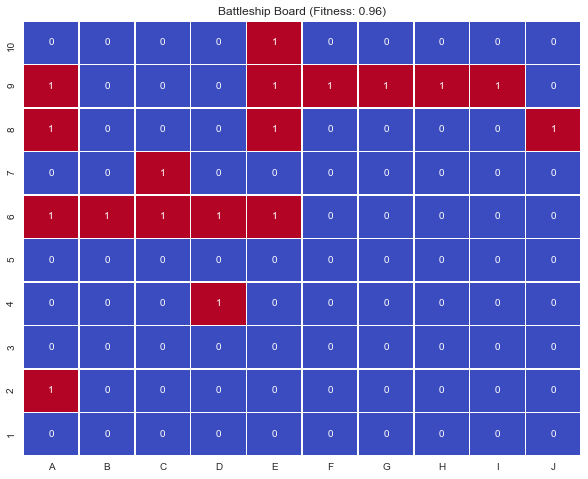

In [9]:
collective_population = GA.reproduce(solution=battleship_solution, num_individuals=10, genes=100)

## Evaluate GA

#### 1) Board Solution

In [10]:
# show the best generation
collective_gene = []
for gene in collective_population[collective_population['Fitness'] == 1.0]['Chromosome'].item():
    collective_gene.append(int(gene))
    
ga_solution = np.array(collective_gene).reshape(10, 10)

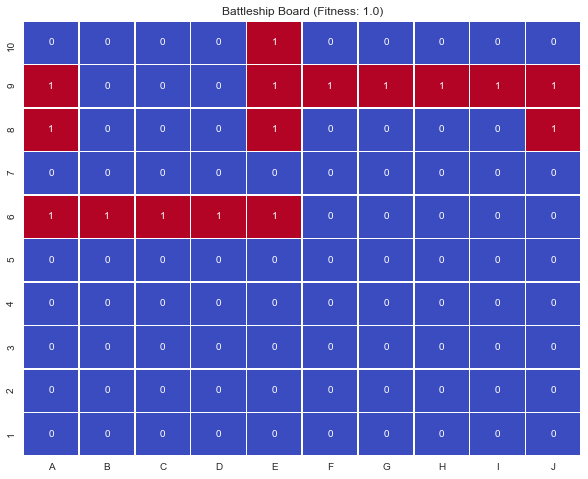

In [11]:
display_heatmap(data=ga_solution, fitness=collective_population[collective_population['Fitness'] == 1.0]['Fitness'].item(), cmap='coolwarm')

#### 2) Solution Statistics

In [12]:
collective_population_stats = collective_population.groupby('Generation').describe()
collective_population_stats.head(10)

Fitness                                                       
             count      mean       std   min     25%    50%     75%   max
Generation                                                               
1             10.0  0.494000  0.026750  0.46  0.4800  0.485  0.5125  0.54
2              4.0  0.535000  0.005774  0.53  0.5300  0.535  0.5400  0.54
14             6.0  0.531667  0.007528  0.52  0.5300  0.530  0.5375  0.54
15             4.0  0.540000  0.000000  0.54  0.5400  0.540  0.5400  0.54
24             6.0  0.541667  0.009832  0.53  0.5400  0.540  0.5400  0.56
25             4.0  0.550000  0.011547  0.54  0.5400  0.550  0.5600  0.56
34             6.0  0.546667  0.015055  0.53  0.5325  0.550  0.5600  0.56
35             4.0  0.560000  0.000000  0.56  0.5600  0.560  0.5600  0.56
44             6.0  0.560000  0.006325  0.55  0.5600  0.560  0.5600  0.57
45             4.0  0.565000  0.005774  0.56  0.5600  0.565  0.5700  0.57

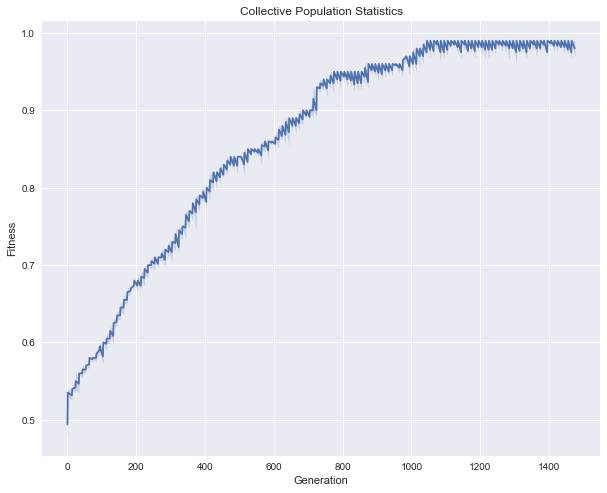

In [13]:
# show the convergence of the best population
plot_population_stats(collective_population)

---